## Intro

This notebook etc...

## Intitialization

In [639]:
using PyPlot
using PyCall
using FITSIO
using Interpolations
using Optim
using Base.Iterators: take, repeated
import Base: getindex
@pyimport camb
@pyimport scipy.integrate as integrate
@pyimport numpy as np
trapz(x,f,axis=0) = integrate.trapz(f,x,axis=axis)
iterrows(A::Matrix) = (A[i,:] for i=1:size(A,1))
itercols(A::Matrix) = (A[:,i] for i=1:size(A,2))

itercols (generic function with 1 method)

## Fiducial model

These can be changed 

In [2]:
const τ   = 0.055
const Aₛ  = 1.882 * exp(2τ) * 1e-9
const nₛ  = 0.9645
const H₀  = 67.27
const h   = H₀/100
const ωb  = 0.02225
const ωc  = 0.1198
const Σmν = 0.06

const kₚ  = 0.05
const T₀  = 2.7255;

const Ωm = (ωc+ωb)/h^2; #TODO: +neutrinos
const ΩΛ = 1 - Ωm;

In [3]:
const c = 299792.458 #in km/s

299792.458

## CMB and matter transfer functions

Here we call CAMB to compute the CMB and matter transfer functions. Note we're computing them at every $\ell$ and at somewhat higher accuracy than normal, so this step may take a few minutes. 

In [739]:
z = collect(linspace(0,3.5,150));

In [740]:
p = camb.set_params(
    As=Aₛ, ns=nₛ, H0=H₀, ombh2=ωb, omch2=ωc, tau=τ, mnu=Σmν, 
    pivot_scalar=kₚ, AccuracyBoost=2, lSampleBoost=50, TCMB=T₀, redshifts=z, k_eta_fac=10, lmax=2600
)
r = camb.get_results(p)
t = r[:get_cmb_transfer_data]()
mt = r[:get_matter_transfer_data]();

In [741]:
ℓ = 1:2508
toCℓ = @. 1/(ℓ*(ℓ+1)/(2π))
CℓTT = @. 1e12*T₀^2 * r[:get_unlensed_scalar_cls](2508)[2:end,1] * toCℓ
CℓEE = @. 1e12*T₀^2 * r[:get_unlensed_scalar_cls](2508)[2:end,2] * toCℓ
CℓTE = @. 1e12*T₀^2 * r[:get_unlensed_scalar_cls](2508)[2:end,4] * toCℓ
Cℓϕϕ = @. r[:get_lens_potential_cls](2508)[2:end,1] / ((ℓ*(ℓ+1))^2/(2π));

Next, take the output from CAMB and put it in our matrix `Wkℓ` $\equiv W_\ell(k)$

$$
C_\ell = \int d\ln k \;W_\ell(k) P_*(k)
$$

where $P_*(k)$ is the primordial power spectrum. 

In [742]:
k = t[:q]
dlnk = diff(log.(k))
dlnk = [dlnk[1]; dlnk];

WkℓTT = @. 4*pi*1e12*T₀^2 * t[:delta_p_l_k][1,:,:]^2
WkℓTT = [zeros(length(k))'; WkℓTT][ℓ,:];

WkℓEE = @. 4*pi*1e12*T₀^2 * t[:delta_p_l_k][2,:,:]^2
WkℓEE = [zeros(length(k))'; WkℓEE][ℓ,:] .* (ℓ.*(ℓ.+1)).^2;

WkℓTE = @. 4*pi*1e12*T₀^2 * t[:delta_p_l_k][1,:,:] .* t[:delta_p_l_k][2,:,:]
WkℓTE = [zeros(length(k))'; WkℓTE][ℓ,:] .* (ℓ.*(ℓ.+1));

Wkℓϕϕ = @. 4*pi * t[:delta_p_l_k][3,:,:]^2
Wkℓϕϕ = [zeros(length(k))'; Wkℓϕϕ][ℓ,:];

We can check this is right by doing the sum over $P_*(k)$ ourselves to verify we get the CMB spectrum back:

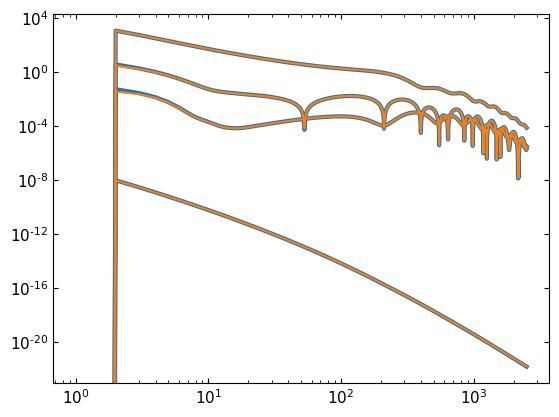

0-element Array{Any,1}

In [743]:
plot(ℓ,      WkℓTT * (Aₛ*(k/kₚ).^(nₛ-1) .* dlnk),  lw=3, c="C0")
plot(ℓ,      WkℓEE * (Aₛ*(k/kₚ).^(nₛ-1) .* dlnk),  lw=3, c="C0")
plot(ℓ, abs.(WkℓTE * (Aₛ*(k/kₚ).^(nₛ-1) .* dlnk)), lw=3, c="C0")
plot(ℓ,      Wkℓϕϕ * (Aₛ*(k/kₚ).^(nₛ-1) .* dlnk),  lw=3, c="C0")


plot(ℓ,      CℓTT,  c="C1")
plot(ℓ,      CℓEE,  c="C1")
plot(ℓ, abs.(CℓTE), c="C1")
plot(ℓ,      Cℓϕϕ,  c="C1")

loglog()

Similarly, the matter transfer functions, such that 
$$P(k) = T(k)^2 P_*(k)$$

In [744]:
Pdat = camb.get_matter_power_interpolator(p, nonlinear=false, hubble_units=false, k_hunit=false, kmax=15, zmax=3.5, extrap_kmax=500)
PNLdat = camb.get_matter_power_interpolator(p, nonlinear=true, hubble_units=false, k_hunit=false, kmax=15, zmax=3.5, extrap_kmax=500)

PyObject <camb.camb.CAMBdata.get_matter_power_interpolator.<locals>.PKInterpolator object at 0x7f007c61d3c8>

In [745]:
Pkz(k,z) = Pdat[:P](z,k)
PNLkz(k,z) = PNLdat[:P](z,k)
Tkz²(k,z) = Pkz(k,z) ./ (Aₛ*(k/kₚ).^(nₛ-1))

getindex(::typeof(Pkz), idx...) = Pkz(idx...)
getindex(::typeof(PNLkz), idx...) = PNLkz(idx...)
getindex(::typeof(Tkz²), idx...) = Tkz²(idx...)

getindex (generic function with 271 methods)

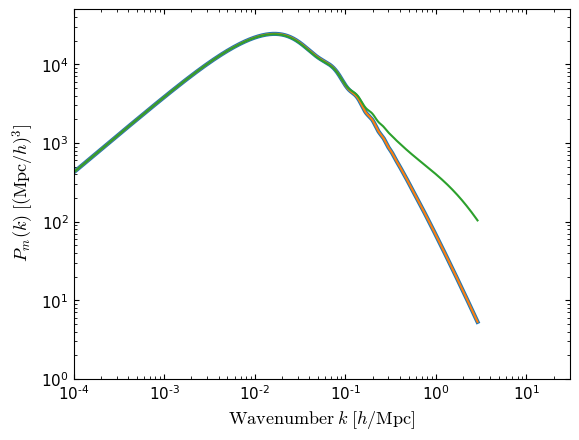

In [746]:
loglog(k/h, h^3 * Tkz²[k,0] .* (Aₛ*(k/kₚ).^(nₛ-1)),lw=3)
loglog(k/h, h^3 *   Pkz[k,0]);
loglog(k/h, h^3 * PNLkz[k,0]);

xlim(1e-4,30)
ylim(1,5e4)
ylabel(raw"$\; P_m(k) \; [({\rm Mpc}/h)^3]$")
xlabel(raw"${\rm Wavenumber} \; k \; [h/{\rm Mpc}]$");

## Planck

### Low-ℓ

In [747]:
toDℓ = (2:29).*((2:29)+1)/(2π)
(d_low_TT, σ_low_TT) = (readdlm("dat/cls_commander_2018_rc_TT.dat")[1:28,i] ./ toDℓ for i=4:5);

### High-ℓ

In [748]:
# the binning specification
blmin, blmax = (round.(Int,readdlm("../dat/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/bl$m.dat")) for m=["min","max"])
bweight = readdlm("../dat/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/bweight.dat");
B_high = hcat([(r=zeros(2508); r[(30+lmin):(30+lmax)]=bweight[(1+lmin):(1+lmax)]; r) for (lmin,lmax) in take(zip(blmin,blmax),214)]...);

# the covariance
Σ_high = (open("../dat/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/c_matrix_plik_v22.dat") do f
    read(f,Int32) #fortran header
    s = read(f,Float64,(613,613))
    (s+s') - diagm(diag(s))
end);
Σ_high_TT = Σ_high[1:214,1:214]
Σ_high_TE = Σ_high[216:414,216:414]
Σ_high_EE = Σ_high[415:end,415:end]


# the data
d_high_TT = readdlm("../dat/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v22.dat")[1:214,2]
d_high_TE = readdlm("../dat/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v22.dat")[216:414,2]
d_high_EE = readdlm("../dat/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v22.dat")[415:end,2];

In [749]:
# for TT, combine low and high-L    
n_low, n_high = length(d_low_TT), length(d_high_TT)
d_planck_TT = [d_low_TT; d_high_TT]
Σ_planck_TT = [diagm(σ_low_TT.^2) zeros(n_low,n_high); zeros(n_high,n_low) Σ_high_TT]
B_planck_TT = [[zeros(1,28); eye(2507,28)] B_high]

nbinsTT = size(B_planck_TT,2);
nbinsEE = size(B_high,2);

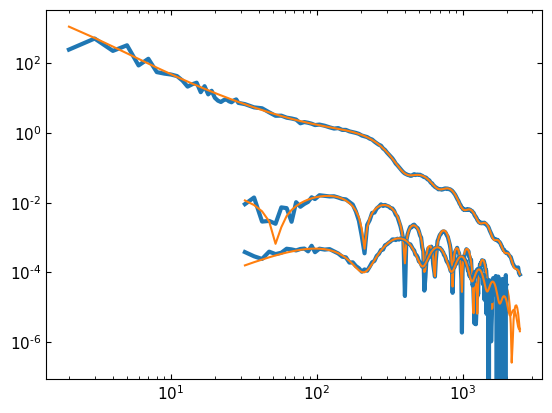

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f006f0f7f98>

In [750]:
let ℓ=1:2508
#check we loaded everything right
loglog((B_planck_TT'*ℓ), d_planck_TT, C="C0", lw=3)
plot(B_planck_TT'*ℓ, B_planck_TT'*CℓTT,c="C1")

loglog((B_high'*ℓ)[1:199], abs.(d_high_TE), c="C0", lw=3)
plot(B_high'*ℓ, B_high'*abs.(CℓTE),c="C1")

loglog((B_high'*ℓ)[1:199], d_high_EE, c="C0", lw=3)
plot(B_high'*ℓ, B_high'*CℓEE,c="C1")
end

### Lensing

In [751]:
d = readdlm("../dat/lensing_aggress.dat")[1:end-2,:];
d_ϕϕ = d[:,3]
Σ_ϕϕ = diagm(d[:,4].^2)
blmin,blmax = Int.(d[:,1]), Int.(d[:,2])
B_ϕϕ = hcat([(r=zeros(2508); r[lmin:lmax]=1/(lmax-lmin+1); r) for (lmin,lmax) in zip(blmin,blmax)]...);

In [850]:
d = readdlm("dat/planck_lensing_2017/smicadx12_Dec5_ftl_mv2_ndclpp_p_teb_agr2_bandpowers.dat")
d_ϕϕ = d[:,5]
Σ_ϕϕ = diagm(d[:,6].^2)
blmin,blmax = Int.(d[:,2]), Int.(d[:,3])
B_ϕϕ = hcat([(r=zeros(2508); r[lmin:lmax]=1/(lmax-lmin+1); r) for (lmin,lmax) in zip(blmin,blmax)]...);

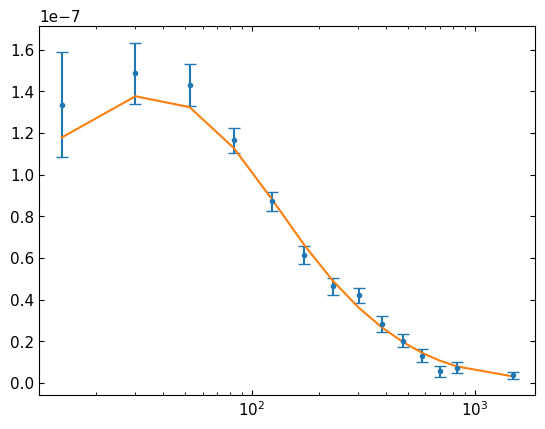

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f006c382588>

In [851]:
errorbar((blmin+blmax)/2, d_ϕϕ, sqrt.(diag(Σ_ϕϕ)),marker=".",ls="")
semilogx((blmin+blmax)/2, B_ϕϕ' * (@. Cℓϕϕ * (ℓ*(ℓ+1))^2/(2π)))

### Make plot

In [753]:
# gets 20/50/80% quantiles of a probability distribution P(x) * dx, 
function get_quantiles(x, Px, dx)
    cs = cumsum(abs.(Px) .* dx)
    cs /= cs[end]
    inz = @. (cs>0) & (cs<1)
    itp = interpolate((cs[inz],),x[inz],Gridded(Linear()))
    itp[[0.2,0.5,0.8]]
end

get_quantiles (generic function with 2 methods)

In [770]:
function get_plot_data(d, Σ, B, Cℓ, Wkℓ, k, nrebin, tg_style=false)
    
    # rebin the data
    lmins = cumsum([1; nrebin])[1:end-1]
    lims = zip(lmins,lmins+nrebin-1)
    nbins = size(B,2)
    B2 = hcat([(r=zeros(nbins); r[l1:l2]=1; normalize!(r,1)) for (l1,l2)=lims]...);
    nbins2 = size(B2,2)
    
    # compute 
    if tg_style
        Wki = B2'*B'*Wkℓ
    else
        Wki = B2'*B'*Wkℓ ./ Tkz²[k,0]'
    end
    Pi = Wki ./ sum(Wki .* dlnk',2)
    ℓkmap = hcat(get_quantiles.((k,),[Pi[i,:] for i=1:nbins2],(dlnk,))...)'
    
    σCℓ_over_Cℓ = sqrt.(diag(B2'*Σ*B2)) ./ (B2'*d)
    f = (B2' * d) ./ (B2' * B' * Cℓ)
    
    σCℓ_over_Cℓ, ℓkmap, f, Pi, B2'*B'*ℓ
    
end
    
function make_plot(σCℓ_over_Cℓ, ℓkmap, f, args...; kwargs...)
    
    # make plot
    m = h^3 * Pkz[ℓkmap[:,2],0]
    errorbar(
        ℓkmap[:,2]/h, 
        m .* f;
        yerr = m .* σCℓ_over_Cℓ,
        xerr = abs.(ℓkmap[:,[1,3]].-ℓkmap[:,2])'/h,
        ebar_kwargs...,
        kwargs...
    )
    
end

make_plot (generic function with 1 method)

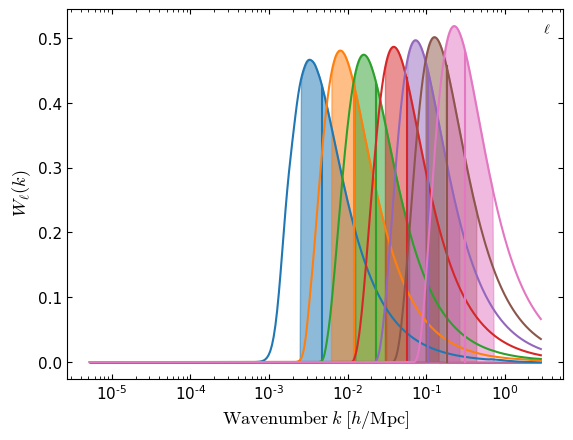

PyObject <matplotlib.legend.Legend object at 0x7f006cd1b550>

In [858]:
# _,ℓkmap,_,Pi,ℓbin = get_plot_data(d_planck_TT, Σ_planck_TT, B_planck_TT,     CℓTT, WkℓTT, k, [[1, 3, 15, 15]; fill(5,2); fill(10,5); fill(20,7)])
# _,ℓkmap,_,Pi,ℓbin = get_plot_data(d_high_EE,   Σ_high_EE,   B_high[:,1:199], CℓEE, WkℓEE, k, [fill(5,2); fill(10,5); fill(20,6); 19])
# _,ℓkmap,_,Pi,ℓbin = get_plot_data(d_high_TE,   Σ_high_TE,   B_high[:,1:199], CℓTE, WkℓTE, k, [fill(5,2); fill(10,5); fill(20,6); 19])
_,ℓkmap,_,Pi,ℓbin = get_plot_data(d_ϕϕ,   Σ_ϕϕ,   B_ϕϕ, Cℓϕϕ, Wkℓϕϕ, k, [1,1,2,2,2,3,3], false)


for i = 1:1:size(ℓkmap,1)
    T = Pi[i,:]
    l, = semilogx(k/h, T)
    low,mid,high = get_quantiles(k, T, [0; diff(log.(k))])
    fill_between(k/h, 0T, T.*ifelse.(low.<k.<high,1,0), color=l[:get_color](), alpha=0.5)
    imid = indmin(@. (k-mid)^2)
    plot(fill(k[imid]/h,2),[0,T[imid]], color=l[:get_color]())

end
ylabel(raw"$\; W_{\ell}(k) $")
xlabel(raw"${\rm Wavenumber} \; k \; [h/{\rm Mpc}]$")
legend(title=raw"$\ell$")

Their method:

$$
d_i = \int d \ln k \; \mathcal{P}_i(k)
$$

what make sense to me:

$$
d_i = \int d \ln k \; W_i(k) P(k)
$$



$$
C_\ell = \int d \ln k \; W_\ell(k) P(k)
$$

## Reid et al. 2010 $P_{halo}(k)$

Here we call the modified version of CAMB to compute the halo matter power spectrum (instead of the linear matter power spectrum), using the fiducial cosmological parameters specified above:

In [756]:
@pyimport camb4py
camb09 = camb4py.load("../src/camb-feb09/camb",defaults="../dat/lrgdr7like/CAMBfeb09patch/params.ini")
Pk_halo = camb09(;Dict(Symbol(k)=>v for (k,v) in Dict(
    "re_optical_depth" => τ,
    "scalar_amp(1)" => Aₛ,
    "scalar_spectral_index(1)" => nₛ,
    "hubble" => H₀,
    "ombh2" => ωb,
    "omch2" => ωc,
    "pivot_scalar" => kₚ,
    "temp_cmb" => T₀
))...)["transfer_matterpower"][2:end,1:2]
Pk_halo = interpolate((Pk_halo[:,1],),Pk_halo[:,2],Gridded(Linear()));

Now we load Reid et al. 2010 data:

In [757]:
(k_reid,d_reid_Pk) = itercols(readdlm("../dat/lrgdr7like/data/lrgdr7_ccmeasurements.txt")[:,[1,4]])
Σ_reid_Pk = inv(readdlm("../dat/lrgdr7like/data/lrgdr7_invcov.txt"))
σ_reid_Pk = sqrt.(diag(Σ_reid_Pk));

Finally, we compute the best fit bias parameters:

In [758]:
Fnuis(k,b₀=1,a₁=0.172,a₂=-0.198) = (kₛ=0.2/h; b₀^2*(1+a₁*(k/kₛ)+a₂*(k/kₛ)^2))
lnL(x) = (Δ = Pk_halo[k_reid] .* Fnuis.(k_reid,x...) - d_reid_Pk; Δ'*(Σ_reid_Pk\Δ))
x_nuis_reid = optimize(lnL,Float64[1,0,0]).minimizer

3-element Array{Float64,1}:
  1.24645 
  0.564531
 -0.354702

## Lyman-alpha forest

In [759]:
function rebin(xs,σs,nperbin)
    istart = cumsum([0; nperbin])[1:end-1]+1
    (tuple(([         mean(x[i:i+n-1])     for (i,n) in zip(istart,nperbin)] for x in xs)...),
     tuple(([sqrt(1/sum(1./σ[i:i+n-1].^2)) for (i,n) in zip(istart,nperbin)] for σ in σs)...))
end

rebin (generic function with 1 method)

In [760]:
k_lyaf, Pk_lyaf, σ_lyaf_Pk    = itercols(readdlm("../dat/lya/pm_z0_final.txt"));
(k_lyaf,Pk_lyaf),(σ_lyaf_Pk,) = rebin((k_lyaf*h,Pk_lyaf),(σ_lyaf_Pk,), [fill(1,7); [2,2,2,2,3,3,3,4,4]]);

## Make plot

In [761]:
ebar_kwargs = Dict(:capsize=>2, :elinewidth=>1, :markeredgewidth=>1, :marker=>".", :ls=>"", :markersize=>4);

In [762]:
rc("axes",labelsize=13,titlesize=13)
rc("xtick",labelsize=11)
rc("ytick",labelsize=11)
rc("legend",fontsize=10)

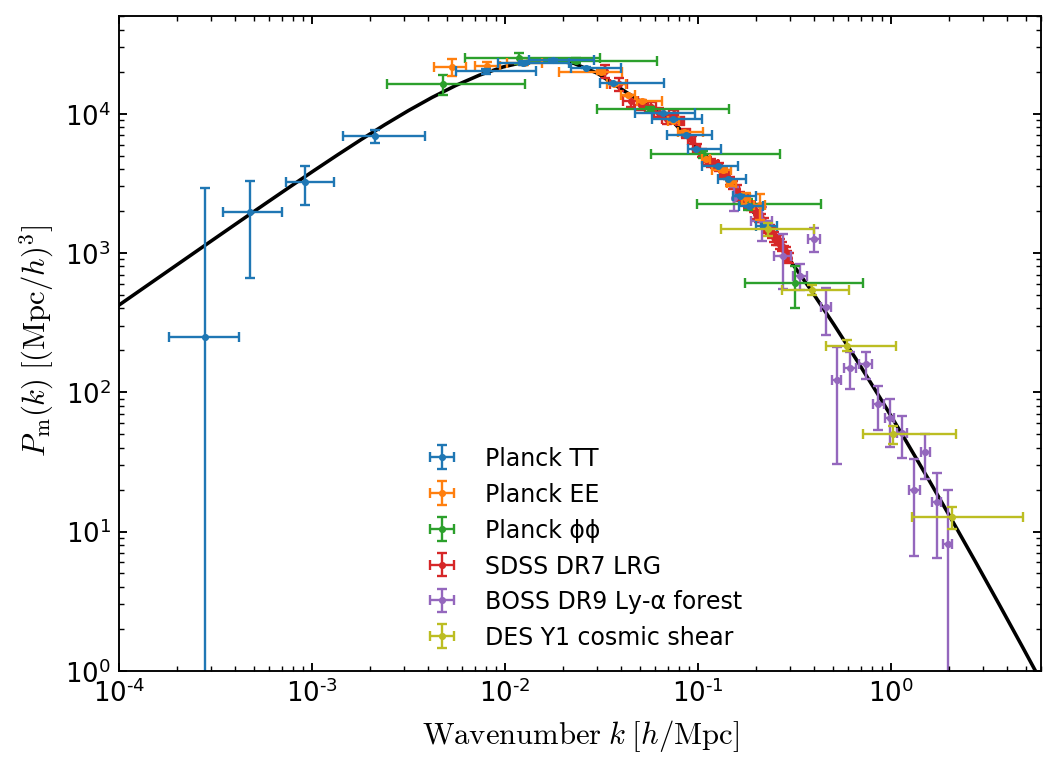

In [860]:
figure(figsize=(7,5),dpi=170)

let k = logspace(-5,1)
    plot(k/h, h^3 * Pkz[k,0],"k", zorder=-10)
end


# Planck
make_plot(get_plot_data(d_planck_TT, Σ_planck_TT, B_planck_TT,     CℓTT, WkℓTT, k, [[1, 3, 5, 20]; fill(5,2); fill(10,5); fill(20,7)])..., label="Planck TT", zorder=-1)
make_plot(get_plot_data(d_high_EE,   Σ_high_EE,   B_high[:,1:199], CℓEE, WkℓEE, k, [fill(5,2); fill(10,5); fill(20,6); 19])...,            label="Planck EE", zorder=-2)
make_plot(get_plot_data(d_ϕϕ,        Σ_ϕϕ,        B_ϕϕ,            (@. Cℓϕϕ * (ℓ*(ℓ+1))^2/(2π)), Wkℓϕϕ, k, [1,1,2,2,2,3,3])...,     label="Planck ϕϕ", zorder=-3)
# make_plot(get_plot_data(d_high_TE,   Σ_high_TE,   B_high[:,1:199], CℓTE, WkℓTE, [fill(5,2); fill(10,5); fill(20,6); 19])...,            label="Planck TE")


# Reid et al. 2010
α_reid = 1 ./ Fnuis.(k_reid,x_nuis_reid...) .* (Pkz[k_reid,0]./Pk_halo[k_reid]) * h^3
errorbar(k_reid/h, α_reid .* d_reid_Pk, yerr=(α_reid .* σ_reid_Pk), xerr = [0; diff(k_reid)], zorder=-1, label="SDSS DR7 LRG", zorder=-5; ebar_kwargs...)

# Lyman-alpha forest
errorbar(k_lyaf/h, Pk_lyaf, yerr = σ_lyaf_Pk, xerr = [0; diff(k_lyaf*h)], label="BOSS DR9 Ly-α forest", zorder=-4; ebar_kwargs...)

# DES
make_plot(σξb ./ ξb_theory, kb_DES, (ξb_data ./ ξb_theory), label="DES Y1 cosmic shear", c="C8")

xscale("log")
yscale("log")
legend(loc="lower center")

xlim(1e-4,6)
ylim(1,5e4)

ylabel(raw"$\; P_{\rm m}(k) \; [({\rm Mpc}/h)^3]$")
xlabel(raw"${\rm Wavenumber} \; k \; [h/{\rm Mpc}]$")

savefig("tegfig.pdf", bbox_inches="tight")

## DES

Calculation assumes:

$$
\begin{align}
\xi_\pm^{ij}(\theta) = \frac{1}{2\pi} \int d\ln k\; \underbrace{\left[ \int_0^{\chi^H} d\chi \; \ell(\ell+1/2) J_{0/4}(\theta\ell)  \frac{q^i(\chi)q^j(\chi)}{\chi^2} \frac{P(k,\chi)}{P(k,0)} \right]}_{ T_{\xi P}(\theta,k)} P(k,0)
\end{align}
$$

where
$$
\begin{align}
k = \frac{\ell+1/2}{\chi}
\end{align}
$$

Load source counts:

In [12]:
nz_source_dat = readdlm("dat/des/DES_1YR_final_nz_source.dat")
zmid = nz_source_dat[:,2]
nz_source = [extrapolate(interpolate((zmid,),nz_source_dat[:,i],Gridded(Linear())),0) for i=4:7];

Load $\theta$-bins in DES data product:

In [13]:
θ_DES_arcmin = readdlm("dat/des/DES_1YR_final_theta_bins.dat")[:]
θ_DES = deg2rad.(θ_DES_arcmin/60)[:];

Load best-fit nuisance parameters:

In [14]:
des_fit = Dict(k=>v for (v,k) in iterrows(readdlm("dat/des/base_DES_DESpriors.minimum")[3:end-2,2:3]));
wl_photoz_errors             = [des_fit["DES_DzS$i"] for i=1:4]
lens_photoz_errors           = [des_fit["DES_DzL$i"] for i=1:5]
bin_bias                     = [des_fit["DES_b$i"] for i=1:5]
shear_calibration_parameters = [des_fit["DES_m$i"] for i=1:4]
intrinsic_alignment_A        = des_fit["DES_AIA"]
intrinsic_alignment_alpha    = des_fit["DES_alphaIA"]
intrinsic_alignment_z0       = 0.62;
shear_calibration = @. (1+shear_calibration_parameters)*(1+shear_calibration_parameters)';

Do calculation:

In [682]:
z = collect(logspace(-4,log10(3.5),5000));
k = logspace(-3,log10(10),600);

In [683]:
χ = r[:comoving_radial_distance](z)
ℓ = @. k*χ'-1/2;
D_growth = @. sqrt(Tkz²[1,z] / Tkz²[1,1]);
Hz = r[:h_of_z](z);

nχ = @. Hz * getindex(nz_source', z - wl_photoz_errors');

Alignment_z = @. intrinsic_alignment_A * (((1 + z) / (1 + intrinsic_alignment_z0)) ^ intrinsic_alignment_alpha) * 0.0134 / D_growth;
w_align = @. Alignment_z * nχ / (χ * (1 + z) * (3/2) * (H₀/c)^2);

w = hcat([[trapz(χ[i:end], (@. nχ[:,j] * (1 - χ[i]/χ))[i:end]) for i=eachindex(χ)] for j=1:4]...);

q = @. (3/2) * Ωm * (H₀/c)^2 * χ * (1 + z) * (w - w_align);

`q` is the lensing efficiency function (this seems right):

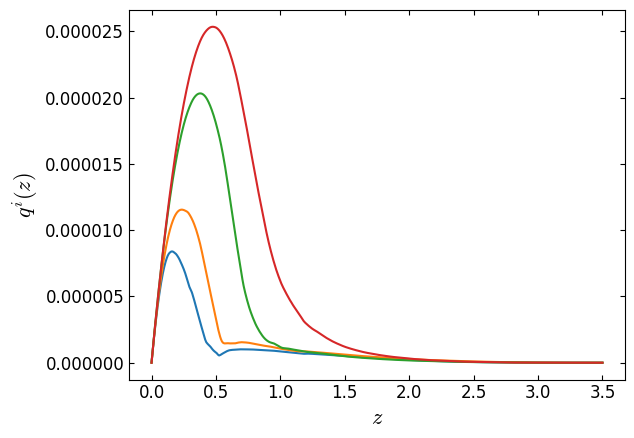

In [684]:
plot(z,q)
xlabel(raw"$z$")
ylabel(raw"$q^i(z)$");

The correlation functions:

In [685]:
ijs = [(i,j) for j=1:4, i=1:4 if i<=j];

In [687]:
Pκ = Dict((i,j) => (@. q[:,i]*q[:,j]/χ^2 * PNLkz[k,z]) for (i,j)=ijs)

@time (ξ₊_θ, ξ₋_θ) = (Dict((i,j) => [0.85/2π * trapz(log.(k), trapz(χ, (@. ℓ*(ℓ+1/2)*besselj(n,θ*ℓ) * Pκ[i,j]'), 1)) * shear_calibration[i,j] for θ=θ_DES] 
    for (i,j)=ijs) for n=(0,4));

 92.459266 seconds (202.69 k allocations: 17.894 GiB, 2.55% gc time)


Clearly not quite right yet:

In [676]:
# load data and covariance
ξ₊_DES  = Dict((i,j)=>x for ((i,j),x) in zip(ijs,itercols(reshape(readdlm("dat/des/DES_1YR_final_xip.dat")[:,4],20,10))))
ξ₋_DES  = Dict((i,j)=>x for ((i,j),x) in zip(ijs,itercols(reshape(readdlm("dat/des/DES_1YR_final_xim.dat")[:,4],20,10))))
covξ₊_DES = readdlm("dat/des/DES_1YR_final_cov.dat")[1:200,1:200]
covξ₋_DES = readdlm("dat/des/DES_1YR_final_cov.dat")[201:400,201:400]
σξ₊_DES = Dict((i,j)=>x for ((i,j),x) in zip(ijs,itercols(reshape(sqrt.(diag(readdlm("dat/des/DES_1YR_final_cov.dat")))[1:200],20,10))));
σξ₋_DES = Dict((i,j)=>x for ((i,j),x) in zip(ijs,itercols(reshape(sqrt.(diag(readdlm("dat/des/DES_1YR_final_cov.dat")))[201:400],20,10))));
ξ₊cut_DES = Dict((i,j)=>[θmin,θmax] for (i,j,θmin,θmax) in iterrows(readdlm("dat/des/DES_1YR_final_selection.dat")[1:10,2:end]));
ξ₋cut_DES = Dict((i,j)=>[θmin,θmax] for (i,j,θmin,θmax) in iterrows(readdlm("dat/des/DES_1YR_final_selection.dat")[11:20,2:end]));

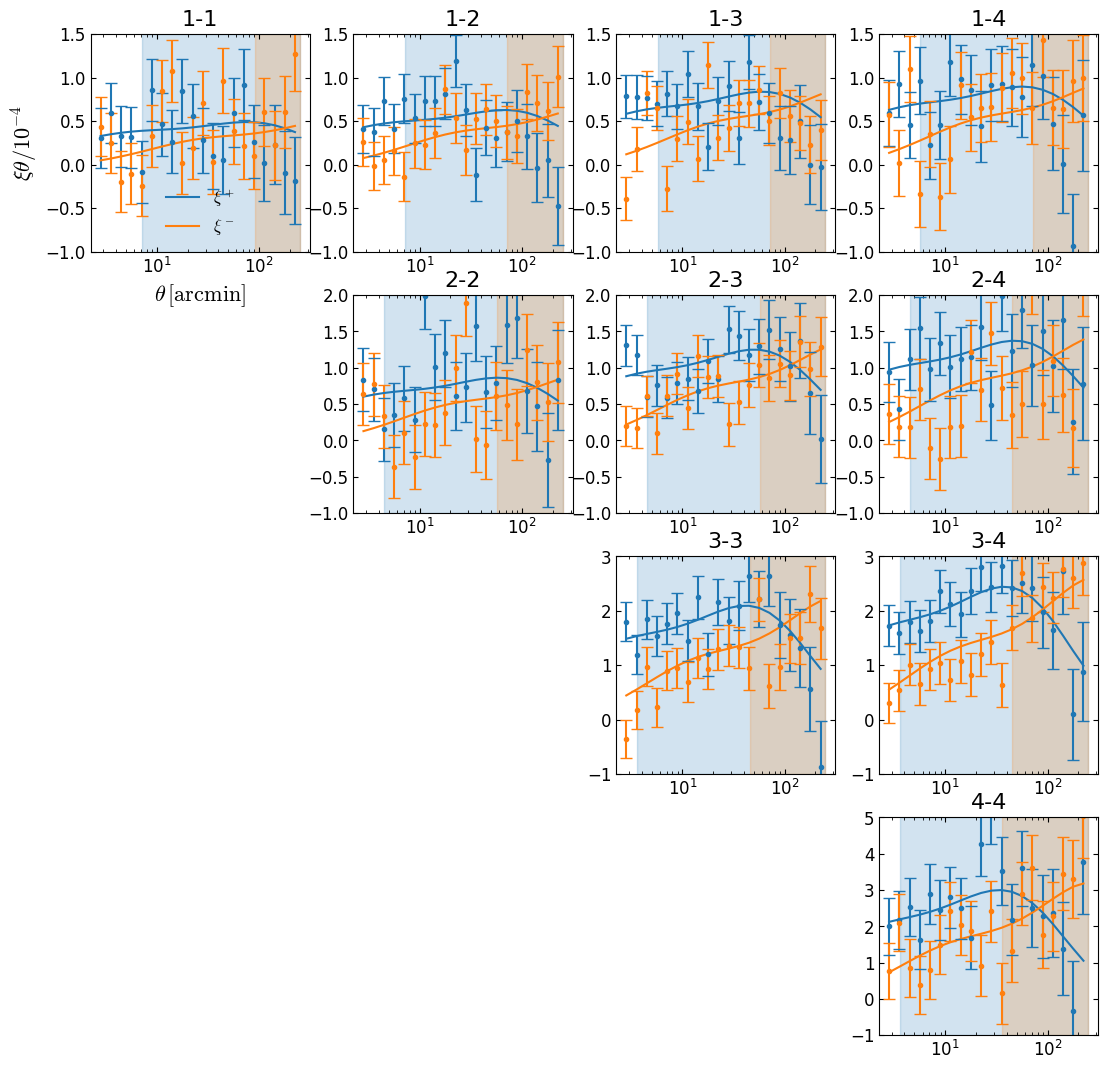

In [692]:
figure(figsize=(13,13))
for i=1:4, j=1:4
    if i<=j
        subplot(4,4,4*(i-1)+j)
        fac = 1e4 * θ_DES_arcmin
        
        semilogx(θ_DES_arcmin, fac .* ξ₊_θ[i,j], c="C0")
        semilogx(θ_DES_arcmin, fac .* ξ₋_θ[i,j], c="C1")
        
        errorbar(θ_DES_arcmin, fac .* ξ₊_DES[i,j], fac .* σξ₊_DES[i,j], marker=".", ls="", c="C0")
        errorbar(θ_DES_arcmin, fac .* ξ₋_DES[i,j], fac .* σξ₋_DES[i,j], marker=".", ls="", c="C1")
        
        title("$i-$j")
        if i==j==1
            legend([raw"$\xi^+$",raw"$\xi^-$"])
            xlabel(raw"$\theta\,[\rm arcmin]$")
            ylabel(raw"$\xi\theta/10^{-4}$")
        end
        ylim(-1,[1.5,2,3,5][i])
        
        let (ymin,ymax)=ylim(); 
            fill_between(ξ₊cut_DES[i,j], fill(ymin,2), fill(ymax,2), color="C0", alpha=0.2)
            fill_between(ξ₋cut_DES[i,j], fill(ymin,2), fill(ymax,2), color="C1", alpha=0.2)
        end

    end
end

These should be the transfer functions that determine which $k$ corresponds to a particular $\theta$ bin:

In [693]:
function fNL(x,n=nₛ)
    A = 0.482*(1+n/3)^-0.947
    B = 0.226*(1+n/3)^-1.778
    α = 3.310*(1+n/3)^-0.244
    β = 0.862*(1+n/3)^-0.287
    V = 11.55*(1+n/3)^-0.423
    g = 5/2*Ωm*(Ωm^(4/7)-ΩΛ+(1+Ωm/2)*(1+ΩΛ/70))^-1
    x * ((1+B*β*x+(A*x)^(α*β)) / (1+(((A*x)^α)*g^3/(V*sqrt(x))^β)))^(1/β)
end

fNL (generic function with 2 methods)

In [694]:
Δ²(k,z=0) = @. 4π*k^3/(2π)^3*Pkz[k,z]
ΔNL²(k,z=0) = @. 4π*k^3/(2π)^3*PNLkz[k,z]

ΔNL² (generic function with 2 methods)

In [695]:
k′_of_k(k,z=0) = k .* (1+fNL.(Δ²(k))./(1+z').^2).^(-1/3)
k_of_k′(k′,z=0) = hcat([interpolate((k′_of_k(k,z),),k,Gridded(Linear()))[k′] for z=z]...)

k_of_k′ (generic function with 2 methods)

In [696]:
k′ = logspace(-3,log10(100),600)
ℓ = max.(0,k_of_k′(k′,z).*χ'-1/2);
dlnk_dlnk′ = [ones(χ)'; diff(log.(k_of_k′(k′,z)),1) ./ diff(log.(k′))];

In [697]:
Pκ = Dict((i,j) => (@. q[:,i]*q[:,j]/χ^2 * Pkz[k′,z] / Pkz[k′,0]') for (i,j)=ijs)

@time (Tξ₊P,Tξ₋P) = (Dict((i,j) => [trapz(χ, (@. dlnk_dlnk′*ℓ*(ℓ+1)*besselj(n,θ*ℓ) * Pκ[i,j]'), 1) for θ=θ_DES]
    for (i,j)=ijs) for n=(0,4));

107.832359 seconds (209.47 k allocations: 17.893 GiB, 2.23% gc time)


Base.Generator{Tuple{Int64,Int64},##1201#1205}(#1201, (0, 4))

In [560]:
# let ℓ=k′.*χ'-1/2
#     @time TξP2 = [trapz(χ, (@. ℓ*(ℓ+1)*besselj(n,θ*ℓ) * Pκ[i,j]'), 1) for i=1:4, j=1:4, n=[0,4], θ=θ_DES]
# end;

In [698]:
killhighfreqnoise(x) = (x=x/sum(abs.(x[1:400])); i=findfirst((x.>1)); x[(i==0 ? end : i-10):end]=0; x[end-10:end]=0; x/sum(abs.(x)))

killhighfreqnoise (generic function with 1 method)

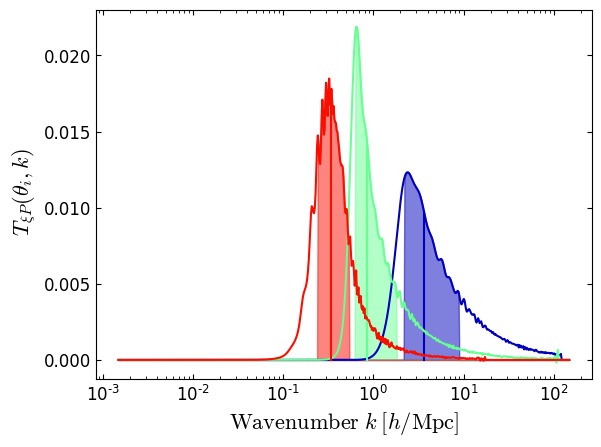

In [699]:
for i=1:1,j=1:1,θ=1:8:20
    T = killhighfreqnoise(Tξ₋P[i,j][θ])
    l, = semilogx(k′/h, T, c=get_cmap("jet",20)(θ))
    low,mid,high = get_quantiles(k′, T, [0; diff(log.(k′))])
    fill_between(k′/h, 0T, T.*ifelse.(low.<k′.<high,1,0), color=l[:get_color](), alpha=0.5)
    imid = indmin(@. (k′-mid)^2)
    plot(fill(k′[imid]/h,2),[0,T[imid]], color=l[:get_color]())
end

# ylim(-0.03,0.03)
ylabel(raw"$\; T_{\xi P}(\theta_i,k)$")
xlabel(raw"${\rm Wavenumber} \; k \; [h/{\rm Mpc}]$");

In [677]:
B = hcat([vcat(repeated([zeros(4*i); ones(4); zeros(20-4*(i+1))],10)...) for i=0:4]...);

  likely near In[677]:1
  likely near In[677]:1
  likely near In[677]:1
  likely near In[677]:1
  likely near In[677]:1
  likely near In[677]:1


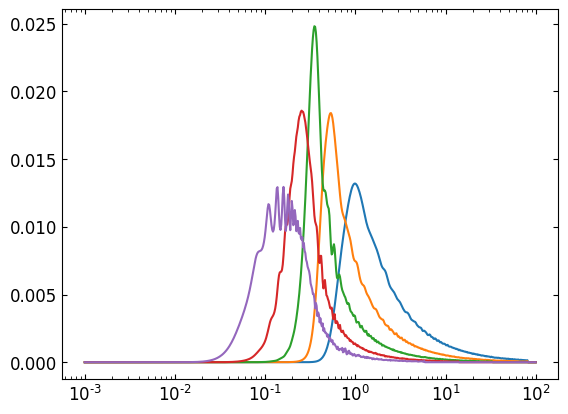

5-element Array{Array{PyCall.PyObject,1},1}:
 PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x7f006ea3b048>]
 PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x7f006e781a20>]
 PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x7f006e761be0>]
 PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x7f006e781ef0>]
 PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x7f006ea3be10>]

In [706]:
semilogx.((k′,), killhighfreqnoise.(B' * vcat((Tξ₋P[i,j] for (i,j)=ijs)...)))

In [709]:
ξb_theory = B' * vcat((ξ₋_θ[i,j] for (i,j) in ijs)...)
ξb_data = B' * vcat((ξ₋_DES[i,j] for (i,j) in ijs)...)
σξb = sqrt.(diag(B'*covξ₋*B));

In [713]:
σξb ./ ξb_theory

5-element Array{Float64,1}:
 0.191382 
 0.110279 
 0.0896645
 0.0872704
 0.105041 

In [736]:
(ξb_data ./ ξb_theory)

5-element Array{Float64,1}:
 1.04664 
 0.774096
 0.991873
 1.03605 
 1.02742 

In [725]:
kb_DES = hcat(get_quantiles.((k′,), killhighfreqnoise.(B' * vcat((Tξ₋P[i,j] for (i,j)=ijs)...)), ([0; diff(log.(k′))],))...)'

5×3 Array{Float64,2}:
 0.858255   1.38359   3.25307 
 0.480776   0.686564  1.46361 
 0.308769   0.398193  0.715909
 0.1835     0.262392  0.408206
 0.0885657  0.154027  0.266716

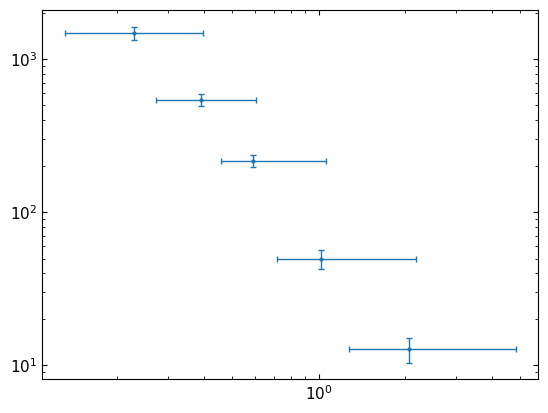

0-element Array{Any,1}

In [791]:
make_plot(σξb ./ ξb_theory, kb_DES, (ξb_data ./ ξb_theory))
loglog()

### Linear Combinations (not used)

In [260]:
θs=collect(1:3)

3-element Array{Int64,1}:
 1
 2
 3

In [261]:
xmin = optimize(x->(T = sum(normalize(TξP[1,1,1,θs]) .* [1; x]); abs(sum((T./k′/sum(T./k′))[T.<0]))), 
    ones(length(θs)-1)).minimizer

2-element Array{Float64,1}:
 -1.81455
  1.98498

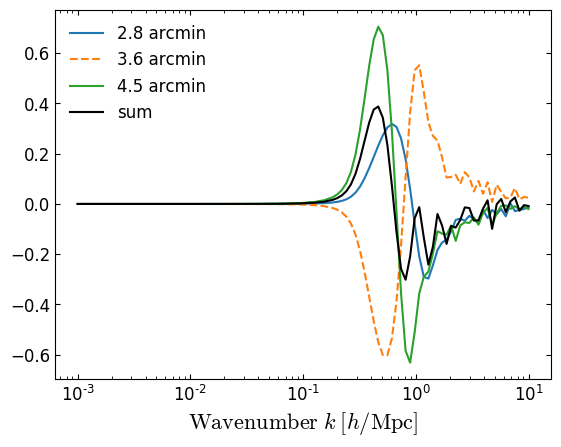

sum(T ./ k′) = 4.889643775004405


In [267]:
let T=sum(normalize.(TξP[1,1,1,θs]) .* [1; xmin]);
    @show sum(T./k′)
    for (w,θ) in zip([1; xmin], θs)
        semilogx(k′, w*normalize(TξP[1,1,1,θ]), label="$(@sprintf("%.1f",θ_DES_arcmin[θ])) arcmin", ls=(w>0 ? "-" : "--"))
    end
    semilogx(k′,T,"k", label="sum")
end
legend()
xlabel(raw"${\rm Wavenumber} \; k \; [h/{\rm Mpc}]$");